In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../../../")


from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [4]:
import tensorflow as tf
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.experimental.net2net import Net2Net
import tensorflow_addons as tfa
from datetime import datetime
from tqdm.auto import tqdm
from pyprojroot.pyprojroot import here

tf.get_logger().setLevel('WARNING')
import warnings
warnings.filterwarnings('ignore')

2022-06-21 08:26:04.885351: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 08:26:05.330788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6


In [6]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/moving_mnist_image_transformer_huggingface.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = cfg["train"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["train"]["n_epochs"]

In [8]:
dataset_length = 10000
num_batch = dataset_length / batch_size

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    first_frame = element[0,...]
    last_frame = element[2,...]
    
    y = element[0:3,...]
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

In [9]:
drop_prob = 0.2

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    #num_elements_to_keep = tf.random.uniform(shape=(1,), minval=5, maxval=tf.shape(element)[0], dtype=tf.int32)
    #remainder = tf.shape(element)[0] - num_elements_to_keep[0]
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    
    #element = element[:10,...]
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

def video_to_ragged(element):
    element["y"] = tf.RaggedTensor.from_tensor(tf.expand_dims(element["y"], 0))
    return element
def squeeze_ragged(element):
    element["y"] = tf.squeeze(element["y"], axis=1)
    return element
def to_tensor(element):
    element["y"] = element["y"].to_tensor()
    return element

dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = (dataset.shuffle(dataset_length, reshuffle_each_iteration=True)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           #.map(video_to_ragged, num_parallel_calls=tf.data.AUTOTUNE)
           )

train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

train_ds = dataset.take(train_size)#.batch(global_batch_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.batch(global_batch_size)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.batch(global_batch_size)

train_sample_data = next(train_ds
                          .padded_batch(batch_size)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(batch_size).as_numpy_iterator())

train_ds = (train_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))

In [10]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    n_frames = tf.shape(element)[0]
    
    remaining_time = tf.cast(tf.linspace(1, 0, n_frames), dtype=tf.float32)
    
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    remaining_time = remaining_time[idx_to_keep]
    
    #element = element[:10,...]
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0], "remaining_time": remaining_time}
def postprocess(batch):
    min_frames = tf.reduce_min(batch["n_frames"])
    first_frame_idx = tf.constant(0)
    frames_to_keep = min_frames - 2
    
    y = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    remaining_times = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    
    for i in tf.range(tf.shape(batch["y"])[0]):
        num_frames = batch["n_frames"][i]
        last_frame_idx = num_frames - 1
        all_indices = tf.range(1, num_frames - 1)
        indices = tf.sort(tf.random.shuffle(all_indices)[:frames_to_keep])
        indices = tf.concat([[first_frame_idx], indices, [last_frame_idx]], axis=0)
        y = y.write(i, tf.gather(batch["y"][i], indices))
        remaining_times = remaining_times.write(i, tf.gather(batch["remaining_time"][i], indices))
        
    batch["remaining_time"] = remaining_times.stack()
    batch["y"] = y.stack()
    batch["n_frames"] = tf.repeat(min_frames, tf.shape(batch["y"])[0])
    
    return batch

In [11]:
dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = (dataset.shuffle(dataset_length, reshuffle_each_iteration=True)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           )

In [12]:
train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [13]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

In [14]:
train_sample_data = next(train_ds
                          .padded_batch(batch_size).map(postprocess)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(batch_size).map(postprocess).as_numpy_iterator())

In [15]:
train_ds = (train_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

In [16]:
train_sample_data["n_frames"]

array([14, 14, 14, 14, 14, 14, 14, 14], dtype=int32)

In [17]:
train_sample_data["y"].shape

(8, 14, 64, 64, 3)

[]

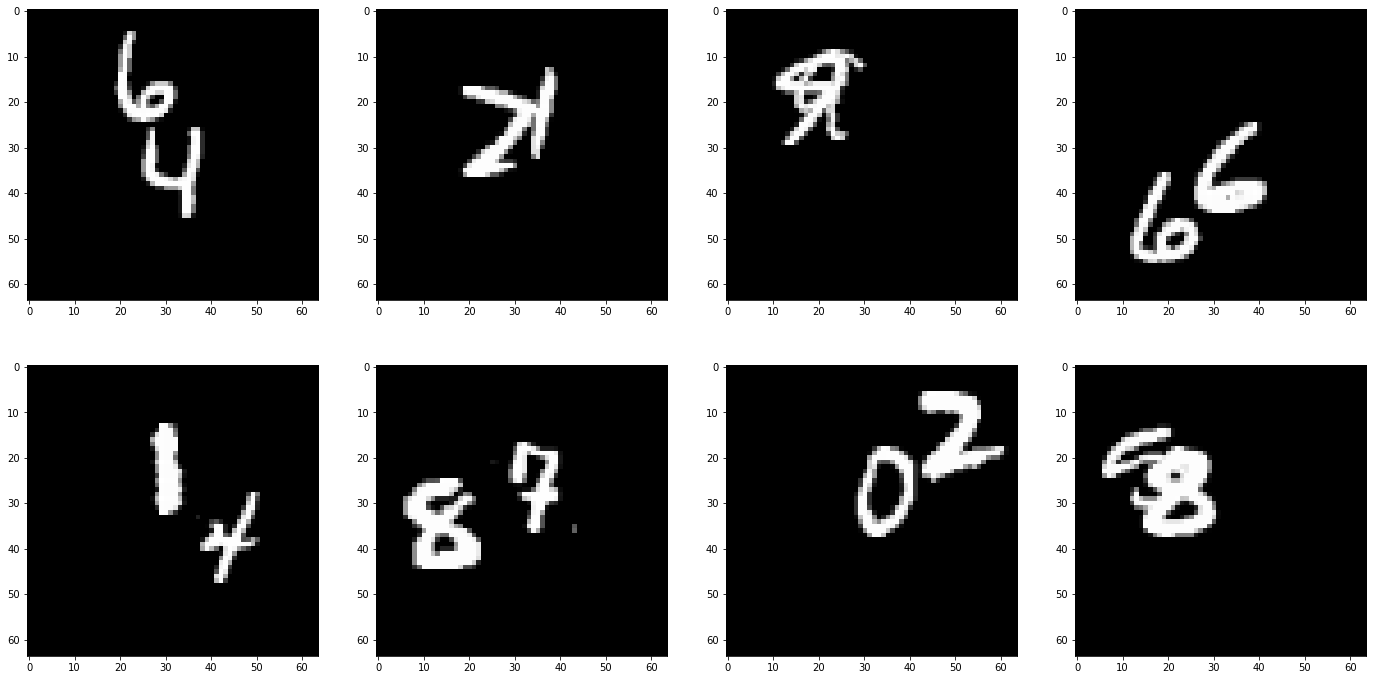

In [18]:
display_images(train_sample_data["last_frame"], 2, 4)
plt.plot()

In [19]:
display_videos(train_sample_data["y"], 2, 4)

train_ds = strategy.experimental_distribute_dataset(train_ds)
validation_ds = strategy.experimental_distribute_dataset(validation_ds)
test_ds = strategy.experimental_distribute_dataset(test_ds)

In [20]:
from ganime.utils.callbacks import TensorboardVideo, get_logdir
import os

logdir = get_logdir("../../../logs/ganime/transformers", experiment_name="mnist_video")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_video_callback = TensorboardVideo(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_loss', save_best_only=True, save_weights_only=True)
#callbacks = [tensorboard_callback, early_stopping, checkpointing, tensorboard_video_callback]
callbacks = [tensorboard_callback, checkpointing, tensorboard_video_callback]

In [22]:
images = train_sample_data["y"][:,0,...]

In [22]:
train_sample_data["y"].shape

(8, 11, 64, 64, 3)

In [46]:
#with strategy.scope():
model = Net2Net(**cfg["model"], trainer_config=cfg["train"])
#model.build(train_sample_data["y"].shape)#first_stage_model.build(train_sample_data["y"].shape[1:])
model.first_stage_model.build(train_sample_data["y"].shape[1:])

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.


All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [24]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [25]:
print_gpu_utilization()

GPU memory occupied: 23889 MB.


for i in range(10):
    pbar = tqdm(train_ds)
    for data in pbar:
        output = strategy.run(model.train_step, args=(data,))
        pbar.set_postfix(loss=output["loss"].numpy())

In [26]:
model.fit(train_ds, validation_data=validation_ds, steps_per_epoch=10, epochs=cfg["train"]["n_epochs"], callbacks=callbacks)

Epoch 1/500


TypeError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/GANime/ganime/model/vqgan_clean/experimental/net2net.py", line 139, in body  *
        cz_indices = tf.concat((last_frame_indices, previous_frame_indices, remaining_time), axis=1)

    TypeError: Tensors in list passed to 'values' of 'ConcatV2' Op have types [int32, int32, float32] that don't all match.


In [ ]:
generated_videos = model(sample)

In [ ]:
display_videos(generated_videos, 2, 4)

In [ ]:
display_videos(train_sample_data["y"], 2, 4)

In [ ]:
quant_z, indices = model.encode_to_z(images)

In [ ]:
quant = model.first_stage_model.quantize.get_codebook_entry(
    indices, shape=tf.shape(quant_z)
)
decoded = model.first_stage_model.decode(quant)

In [ ]:
display_images(model.first_stage_model(images)[0])
plt.show()

In [ ]:
display_images(generated_videos[:,0,...])